In [25]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.mongoexp import MongoTrials
from types import SimpleNamespace

import os
from datetime import datetime
import sys
import time
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold  # trainML
except:
    sys.path.append("../input/iterative-stratification")  # kaggle
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [26]:
BASE_PATH = os.environ.get('TRAINML_DATA_PATH') if os.environ.get('TRAINML_DATA_PATH') else '../input/lish-moa'
BASE_PATH

'/opt/trainml/input'

In [27]:
train_features = pd.read_csv(f'{BASE_PATH}/train_features.csv')
train_targets = pd.read_csv(f'{BASE_PATH}/train_targets_scored.csv')
test_features = pd.read_csv(f'{BASE_PATH}/test_features.csv')

sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

### Data preprocessing

In [28]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

train_data = preprocess(train_features)
test_data = preprocess(test_features)

del train_targets['sig_id']

train_targets = train_targets.loc[train_data['cp_type']==0].reset_index(drop=True)
train_data = train_data.loc[train_data['cp_type']==0].reset_index(drop=True)

In [29]:
X_original = train_data.values
Y_original = train_targets.values

X_test = test_data.values

### Data augmentation helper functions

Currently only doing data oversampling with MLSMOTE algorithm.

In [30]:
def get_tail_labels(df: pd.DataFrame, ql=[0.03, 1.]) -> list:
    " Find the underepresented targets a.k.a. minority labels. "
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_labels = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_labels

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.03, 1.]):
    " Find minority samples associated with minority labels. "
    tail_labels = get_tail_labels(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    " Find nearest neighbors for each sample in X dataframe. "
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_samples, n_neighbors=5):
    " Generate new samples using MLSMOTE algorithm. "
    indices2 = nearest_neighbour(X, neigh=n_neighbors)
    n = len(indices2)
    new_X = np.zeros((n_samples, X.shape[1]))
    target = np.zeros((n_samples, y.shape[1]))
    for i in range(n_samples):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

def augment_data(X, y, oversample_args: tuple):
    " Augment feature/targets data (just doing oversampling for now)"
    n_samples, n_neighbors = oversample_args

    X_sub, y_sub = get_minority_samples(X, y)
    X_res, y_res = MLSMOTE(X_sub, y_sub, n_samples, n_neighbors)
    X_augmented = pd.concat([X, X_res])
    y_augmented = pd.concat([y, y_res])
    return X_augmented, y_augmented

### Define model, dataset, gradient descent

In [31]:
class MoaModel(nn.Module):
    def __init__(    
        self,
        n_columns,
        n_targets,
        layer1_outputs,
        layer1_dropout,
        layer2_outputs,
        layer2_dropout,
        layer3_enable,
        layer3_outputs,
        layer3_dropout,
        final_layer_dropout,
    ):
        super(MoaModel, self).__init__()   
        self.batch_norm1 = nn.BatchNorm1d(n_columns)
        self.dropout1 = nn.Dropout(layer1_dropout)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_columns, layer1_outputs))
        
        self.batch_norm2 = nn.BatchNorm1d(layer1_outputs)
        self.dropout2 = nn.Dropout(layer2_dropout)
        self.dense2 = nn.utils.weight_norm(nn.Linear(layer1_outputs, layer2_outputs))
        
        self.layer3 = layer3_enable
        if self.layer3:
            self.batch_norm3 = nn.BatchNorm1d(layer2_outputs)
            self.dropout3 = nn.Dropout(layer3_dropout)
            self.dense3 = nn.utils.weight_norm(
                nn.Linear(layer2_outputs, layer3_outputs)
            )
            
        final_layer_inputs = layer3_outputs if self.layer3 else layer2_outputs
        self.batch_norm_final = nn.BatchNorm1d(final_layer_inputs)
        self.dropout_final = nn.Dropout(final_layer_dropout)
        self.dense_final = nn.utils.weight_norm(nn.Linear(final_layer_inputs, n_targets))
        
    def forward(self, X):
        X = self.batch_norm1(X)
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))
        
        X = self.batch_norm2(X)
        X = self.dropout2(X)
        X = F.relu(self.dense2(X))
        
        if self.layer3:
            X = self.batch_norm3(X)
            X = self.dropout3(X)
            X = F.relu(self.dense3(X))
            
        X = self.batch_norm_final(X)
        X = self.dropout_final(X)
        X = F.sigmoid(self.dense_final(X))
        
        return X
    
    def _load_from_file(self, file):
        self.load_state_dict(torch.load(file))
        
    def save(self, file):
        torch.save(self.state_dict(), file)
        
def batch_gd(model, device, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for it in range(epochs):
        t0 = datetime.now()

        model.train()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item() / len(train_loader))

        train_loss = np.mean(train_loss)

        model.eval()
        val_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item() / len(val_loader))
        val_loss = np.mean(val_loss)

        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
#         print(
#             f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration {dt}"
#         )

    return train_losses, val_losses

In [32]:
class MoaDataset(Dataset):
    def __init__(self, features, targets, mode="train"):
        self.mode = mode
        self.data = features
        if mode == "train":
            self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == "train":
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(
                self.targets[idx]
            )
        elif self.mode == "eval":
            return torch.FloatTensor(self.data[idx]), 0

### Helper functions for hyperopt's `objective`

In [33]:
def augment_data(X, y, n_samples, n_neighbors):
    """
    Augment feature/targets data with oversampling (using MLSMOTE algorithm)
    """
    X_sub, y_sub = get_minority_samples(X, y)
    X_res, y_res = MLSMOTE(X_sub, y_sub, n_samples, n_neighbors)
    X_augmented = pd.concat([X, X_res])
    y_augmented = pd.concat([y, y_res])
    return X_augmented, y_augmented


def make_model(
        n_columns,
        n_targets,
        layer1_outputs,
        layer1_dropout,
        layer2_outputs,
        layer2_dropout,
        layer3_enable,
        layer3_outputs,
        layer3_dropout,
        final_layer_dropout,
        device
    ):
    """
    Make a 2 or 3 layer neural network with specified outputs and dropout per layer.
    """
    model = MoaModel(n_columns, n_targets, layer1_outputs, layer1_dropout, layer2_outputs,
                   layer2_dropout, layer3_enable, layer3_outputs, layer3_dropout, final_layer_dropout)
    model.to(device)
    return model


def train(model, device, optimizer, X, Y, n_splits, batch_size, epochs):
    """
    Run model training with a stratified k-fold cross validation split according to specified
    parameters. Returns tuple (train_losses, val_losses).
    """
    kfold = MultilabelStratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    criterion = nn.BCELoss()

    train_losses = np.array([])
    val_losses = np.array([])

    for n, (tr, te) in enumerate(kfold.split(X, Y)):
        X_train, X_val = X[tr], X[te]
        y_train, y_val = Y[tr], Y[te]

        train_dataset = MoaDataset(X_train, y_train)
        val_dataset = MoaDataset(X_val, y_val)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset, batch_size=batch_size, shuffle=False
        )
        split_train_losses, split_val_losses = batch_gd(
            model, device, criterion, optimizer, train_loader, val_loader, epochs
        )
#         print(
#             f"Fold {n+1}, final train loss: {split_train_losses[epochs-1]:5.5f}, final train loss: {split_val_losses[epochs-1]:5.5f}"
#         )
        train_losses = np.concatenate((train_losses, split_train_losses))
        val_losses = np.concatenate((val_losses, split_val_losses))

    model.save("latest_model")
    return train_losses, val_losses


def predict(model, device, data_loader):
    """
    Generate label predictions given trained model and feature data.
    """
    model.eval()
    preds = []

    for inputs, _ in data_loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def calculate_loss(model, device, X_eval, Y_eval, batch_size):
    """
    Feed original data set into trained model and generate log-loss score.
    """
    eval_dataset = MoaDataset(X_eval, None, mode='eval')
    eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False)
    preds = predict(model, device, eval_loader)
    
    loss_fn = nn.BCELoss()
    Y_pred = torch.from_numpy(preds.astype(float))
    Y_true = torch.from_numpy(Y_eval.astype(float))
    loss = loss_fn(Y_pred, Y_true)
    return loss.item()

### Hyperopt config - objective function and search space

In [34]:
def objective(space):
    args = SimpleNamespace(**space)
    
    # Augment data
    X_original = args.train_data.values
    Y_original = args.train_targets.values
    train_data, train_targets = augment_data(args.train_data, args.train_targets, args.n_samples, args.n_neighbors)
    X = train_data.values
    Y = train_targets.values
    
    # Build model architecture
    device = args.device
    with torch.cuda.device('cuda:0'):
        torch.cuda.empty_cache()
    model = make_model(
                args.n_columns,
                args.n_targets,
                args.layer1_outputs,
                args.layer1_dropout,
                args.layer2_outputs,
                args.layer2_dropout,
                args.layer3_enable,
                args.layer3_outputs,
                args.layer3_dropout,
                args.final_layer_dropout,
                device
    )

    # Train model
    optimizer = None
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif args.optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters())
    elif args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif args.optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters())
    train_losses, val_losses = train(model, device, optimizer, X, Y, args.n_splits, args.batch_size, args.epochs)
    
    # Calculate loss
    loss = calculate_loss(model, device, X_original, Y_original, args.batch_size)
    
    # Move model out of GPU
    model.to('cpu')

    return {
        'loss': loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model_result': model,
        'status': STATUS_OK,
        'eval_time': time.time()
    }
    

space = {
    # general
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'train_data': train_data,
    'train_targets': train_targets,
    
    # data augmentation
    'n_samples': hp.randint('n_samples', 5000),
    'n_neighbors': 3 + hp.randint('n_neighbors', 10),
    
    # model architecture
    'n_columns': train_data.shape[1],
    'n_targets': train_targets.shape[1],
    'layer1_outputs': 256 + hp.randint('layer1_outputs', 4096),
    'layer1_dropout': hp.uniform('layer1_dropout', 0, 1),
    'layer2_outputs': 256 + hp.randint('layer2_outputs', 4096),
    'layer2_dropout': hp.uniform('layer2_dropout', 0, 1),
    'layer3_enable': hp.choice('layer3_enable', [True, False]),
    'layer3_outputs': 256 + hp.randint('layer3_outputs', 4096),
    'layer3_dropout': hp.uniform('layer3_dropout', 0, 1),
    'final_layer_dropout': hp.uniform('final_layer_dropout', 0, 1),
    
    # cross-validation
    'optimizer': hp.choice('optimizer', ['adam', 'adagrad', 'sgd', 'rmsprop']),
    'n_splits': 5 + hp.randint('n_splits', 10),
    'batch_size': 64 + hp.randint('batch_size', 4096),
    'epochs': 10 + hp.randint('epochs', 90)
}

### Run model training via hyperopt

In [35]:
trials = Trials() # TODO: Make it MongoTrials
best = fmin(
    objective,
    space=space,
    algo=tpe.suggest,
    max_evals=75,
    trials=trials
    # max_queue_len=4 <-- what again is this used for? multiple workers?
)
print(best)

  0%|          | 0/75 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  1%|▏         | 1/75 [09:13<11:22:33, 553.42s/trial, best loss: 0.014418572537595249]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  3%|▎         | 2/75 [14:00<9:36:04, 473.49s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  4%|▍         | 3/75 [24:20<10:20:54, 517.42s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  5%|▌         | 4/75 [32:54<10:11:13, 516.53s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  7%|▋         | 5/75 [46:01<11:37:12, 597.61s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  8%|▊         | 6/75 [55:09<11:10:00, 582.62s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  9%|▉         | 7/75 [1:02:08<10:04:55, 533.76s/trial, best loss: 0.0020801631529383537]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 11%|█         | 8/75 [1:08:44<9:09:38, 492.21s/trial, best loss: 0.0020801631529383537] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 12%|█▏        | 9/75 [1:11:01<7:04:22, 385.80s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 13%|█▎        | 10/75 [1:17:32<6:59:29, 387.22s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 15%|█▍        | 11/75 [1:19:57<5:35:41, 314.71s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 16%|█▌        | 12/75 [1:33:11<8:01:20, 458.42s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 17%|█▋        | 13/75 [1:39:57<7:37:19, 442.58s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 19%|█▊        | 14/75 [1:46:53<7:21:58, 434.73s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 20%|██        | 15/75 [1:54:16<7:17:14, 437.25s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 21%|██▏       | 16/75 [1:57:44<6:02:18, 368.44s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 23%|██▎       | 17/75 [2:02:23<5:30:04, 341.46s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 24%|██▍       | 18/75 [2:07:24<5:12:57, 329.43s/trial, best loss: 0.0009534722227026915]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 25%|██▌       | 19/75 [2:19:10<6:53:02, 442.55s/trial, best loss: 0.0005206368610764695]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 27%|██▋       | 20/75 [2:31:41<8:10:29, 535.09s/trial, best loss: 0.0005206368610764695]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 28%|██▊       | 21/75 [2:42:30<8:32:14, 569.16s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 29%|██▉       | 22/75 [2:53:04<8:40:01, 588.71s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 31%|███       | 23/75 [3:11:27<10:43:52, 742.93s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 32%|███▏      | 24/75 [3:17:36<8:56:05, 630.69s/trial, best loss: 0.0001935222140223162] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 33%|███▎      | 25/75 [3:20:47<6:55:37, 498.76s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 35%|███▍      | 26/75 [3:26:32<6:09:40, 452.66s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 36%|███▌      | 27/75 [3:30:21<5:08:21, 385.45s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 37%|███▋      | 28/75 [3:36:25<4:57:02, 379.21s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 39%|███▊      | 29/75 [3:42:00<4:40:31, 365.91s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 40%|████      | 30/75 [3:53:00<5:40:26, 453.93s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 41%|████▏     | 31/75 [4:00:21<5:30:11, 450.25s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 43%|████▎     | 32/75 [4:16:27<7:13:25, 604.79s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 44%|████▍     | 33/75 [4:32:35<8:19:43, 713.89s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 45%|████▌     | 34/75 [4:47:09<8:40:44, 762.07s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 47%|████▋     | 35/75 [4:51:17<6:45:11, 607.79s/trial, best loss: 0.0001935222140223162]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 48%|████▊     | 36/75 [5:07:38<7:47:47, 719.69s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 49%|████▉     | 37/75 [5:20:27<7:45:14, 734.59s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 51%|█████     | 38/75 [5:26:57<6:29:13, 631.18s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 52%|█████▏    | 39/75 [5:38:49<6:33:13, 655.37s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 53%|█████▎    | 40/75 [5:47:24<5:57:43, 613.25s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 55%|█████▍    | 41/75 [5:54:55<5:19:58, 564.65s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 56%|█████▌    | 42/75 [5:57:21<4:01:24, 438.91s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 57%|█████▋    | 43/75 [6:10:45<4:52:34, 548.59s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 59%|█████▊    | 44/75 [6:17:40<4:22:43, 508.49s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 60%|██████    | 45/75 [6:22:22<3:40:17, 440.59s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 61%|██████▏   | 46/75 [6:26:30<3:04:54, 382.56s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 63%|██████▎   | 47/75 [6:30:32<2:38:54, 340.52s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 64%|██████▍   | 48/75 [6:36:15<2:33:35, 341.33s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 65%|██████▌   | 49/75 [6:39:50<2:11:25, 303.28s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 67%|██████▋   | 50/75 [6:43:08<1:53:13, 271.76s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 68%|██████▊   | 51/75 [6:51:26<2:15:50, 339.62s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 69%|██████▉   | 52/75 [6:57:27<2:12:40, 346.10s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 71%|███████   | 53/75 [7:03:22<2:07:50, 348.67s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 72%|███████▏  | 54/75 [7:05:36<1:39:31, 284.36s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 73%|███████▎  | 55/75 [7:13:53<1:56:03, 348.18s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 75%|███████▍  | 56/75 [7:18:40<1:44:26, 329.80s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 76%|███████▌  | 57/75 [7:37:21<2:50:08, 567.17s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 77%|███████▋  | 58/75 [7:45:27<2:33:48, 542.83s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 79%|███████▊  | 59/75 [7:51:37<2:10:54, 490.88s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 80%|████████  | 60/75 [7:58:53<1:58:36, 474.44s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 81%|████████▏ | 61/75 [8:04:21<1:40:26, 430.46s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 83%|████████▎ | 62/75 [8:12:30<1:37:03, 447.96s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 84%|████████▍ | 63/75 [8:20:11<1:30:25, 452.14s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 85%|████████▌ | 64/75 [8:28:10<1:24:21, 460.14s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 87%|████████▋ | 65/75 [8:59:48<2:28:32, 891.28s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 88%|████████▊ | 66/75 [9:14:11<2:12:27, 883.05s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 89%|████████▉ | 67/75 [9:27:14<1:53:44, 853.00s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 91%|█████████ | 68/75 [9:35:16<1:26:31, 741.65s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 92%|█████████▏| 69/75 [9:45:54<1:11:03, 710.51s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 93%|█████████▎| 70/75 [9:53:40<53:05, 637.10s/trial, best loss: 1.8641820335377687e-05]  

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 95%|█████████▍| 71/75 [9:55:29<31:54, 478.69s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 96%|█████████▌| 72/75 [10:11:53<31:30, 630.18s/trial, best loss: 1.8641820335377687e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 97%|█████████▋| 73/75 [10:26:59<23:46, 713.06s/trial, best loss: 6.290261839927516e-06] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 99%|█████████▊| 74/75 [10:41:01<12:31, 751.62s/trial, best loss: 6.290261839927516e-06]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



100%|██████████| 75/75 [11:01:03<00:00, 528.85s/trial, best loss: 6.290261839927516e-06]
{'batch_size': 2060, 'epochs': 67, 'final_layer_dropout': 0.1877439227236821, 'layer1_dropout': 0.14529500026984718, 'layer1_outputs': 2578, 'layer2_dropout': 0.3808873747217649, 'layer2_outputs': 1380, 'layer3_dropout': 0.17384030350702706, 'layer3_enable': 0, 'layer3_outputs': 2231, 'n_neighbors': 3, 'n_samples': 12, 'n_splits': 9, 'optimizer': 0}


In [37]:
best

{'batch_size': 2060,
 'epochs': 67,
 'final_layer_dropout': 0.1877439227236821,
 'layer1_dropout': 0.14529500026984718,
 'layer1_outputs': 2578,
 'layer2_dropout': 0.3808873747217649,
 'layer2_outputs': 1380,
 'layer3_dropout': 0.17384030350702706,
 'layer3_enable': 0,
 'layer3_outputs': 2231,
 'n_neighbors': 3,
 'n_samples': 12,
 'n_splits': 9,
 'optimizer': 0}

In [38]:
trials.results[0].keys()

dict_keys(['loss', 'train_losses', 'val_losses', 'model_result', 'status', 'eval_time'])

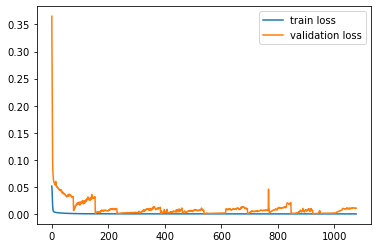

In [39]:
train_losses = trials.results[-1]['train_losses']
val_losses = trials.results[-1]['val_losses']

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

---
#### **NOTE:** Two options.

#### 1) Export model parameters
Use the values in the dict `best` to manually build a "best" model within the Kaggle environment.

#### 2) Export trained model
Looking at `fmin`'s log in console above, it appears that the jump to the lowest "best loss" score occurred at trial 36. So we can just fetch the trained model from trial 36 stored in Trials, serialize it with `torch.save`, and import the file in the Kaggle environment.

---

### 2) Export trained model

In [55]:
best_model = trials.results[35]['model_result']
torch.save(best_model, 'model.pt')

### Generate predictions

(Replicate this cell in Kaggle environment)

In [56]:
batch_size = best['batch_size']
device = space['device']

test_dataset = MoaDataset(X_test, None, mode='eval')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = torch.load('model.pt', map_location='cuda:0')
preds = predict(model, device, test_loader)

### Make competition submission file
(Replicate this cell in Kaggle environment)

In [58]:
targets = [col for col in train_targets.columns]
sample_submission[targets] = preds
sample_submission.loc[test_features['cp_type']=='ctl_vehicle', targets] = 0
sample_submission.to_csv('submission.csv', index=False)